# What the project needs:

   ### Graphs:
- [x] [Bar Plot](#Bar-Plot)
- [Pie Chart](#Pie-Chart)
- [Histogram](#Histogram-Plot)
- [Box and Whisker Plot](#Box-and-Whisker-Plot)
- [x] [Scatter Plot](#Scatter-Plot)
- [x] [Pair Plots](#Pair-Plots)
- [x] [Map Overlay](#Map-Overlay)
- [x] [Line Plot](#Line-Plot)
- Any extra grphs if time permits

   ### Maps:
         [check] Map underlay of scatter plot
         Any cool maps if time permits
   ### Explanations:
        Describe what each visualization is showing and what makes it different from others
        advantages and disadvantages of visual
        
         
         


## Contents

1. Data
2. Getting Started
3. Graphs
 - [x] [Bar Plot](#Bar-Plot)
 - [Pie Chart](#Pie-Chart)
 - [Histogram](#Histogram-Plot)
 - [Box and Whisker Plot](#Box-and-Whisker-Plot)
 - [x] [Scatter Plot](#Scatter-Plot)
 - [x] [Pair Plots](#Pair-Plots)
 - [x] [Map Overlay](#Map-Overlay)
 - [x] [Line Plot](#Line-Plot)
 - Any extra grphs if time permits
4. Conclusions

   ### Maps:
         [check] Map underlay of scatter plot
         Any cool maps if time permits


# Global Terrorism DataSet Analysis in Visualization: 


    - Where from?
    - Items
    - Scope
    - Contributors

Goals:
    - ...


## Getting Started:
### Steps:
    1) Import necessary libraries.
    2) Write Any Needed Functions.
    2) Import Original Data.
    3) Clean Data based on bad entries, missing information, etc...
    4) Save cleaned data to a new file to keep the original unedited.
    5) Import cleaned data and begin to analyze.

####  Import Libraries:

In [15]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.collections as mcol
from matplotlib import cm

# from mpl_toolkits.basemap import Basemap

#use this style of plots
plt.style.use('ggplot') 
#print plots in notebook
%matplotlib inline 

import sklearn as sk
from sklearn.cluster import *
from sklearn.preprocessing import OneHotEncoder

### Functions:
#### Convert Event ID To Datetime Format:

In [2]:
def convert_eventid_to_datetime(df, ignore_bad_data=True):
    """Converts dataframe with event_id column to date time formats. Returns new DF with additional 'datetime' column."""
    from datetime import datetime
    
    datetime_series = []
    ix_to_drop = []
    count = 0
    for i, row in df.iterrows():
        try:
            year = int(row['iyear'])
            month = int(row['imonth'])
            day = int(row['iday'])
            datetime_series.append( datetime(year, month, day) )
        except:
            ix_to_drop.append(count)
            if not ignore_bad_data:
                print("Bad Event ID date format: {}, {}, {}. Event ID: {}"
                      .format(year, month, day, row['eventid']) )
                raise ValueError('Event Id data contains bad dates.')
        count += 1
        
    print('Dropped {} malformed event id rows out of {}.'.format(len(ix_to_drop), df.shape[0]))
    df = df.drop(df.index[ix_to_drop])
    df['datetime'] = pd.to_datetime(datetime_series)
    
    return df

#### Steps 2-5: import, clean, create new data, and sub-sample data
    1) Read in dataframe, specifying subset of columns.
    2) Clean Data, dropping any NAN values from data set.
    3) Use Convert to date time function.
    4) Optionally sub-sample data to manageable size
    5) Save as new data frame.

In [3]:
#read in the data file and make into a pandas dataframe: location, only specific columns
original_df = pd.read_csv('./inputs/globalterrorismdb.csv', encoding='ISO-8859-1', usecols=['eventid', 'iyear', 'imonth', 'iday', 'country', 'region', 
                         'latitude', 'longitude', 'crit1', 'crit2', 'crit3', 'attacktype1','targtype1','targsubtype1','weaptype1',
                          'weapsubtype1'],
                         dtype={'iyear':'int', 'imonth':'int', 'iday':'int'});

#use a manageable sample size
num_rows = 10000 # Reduce to 10k for testing plots
#shows the size of the original data
# print('Original shape of CSV: {}'.format(original_df.shape))

# DropNA() is dropping all NaN values from the dataset. Talk about potential bias. Investigate what causes this bad data.
#Free up memory by deleting the unused origial data
terrorism_df = original_df.dropna().sample(n=num_rows)
del original_df
print(type(terrorism_df))

#displays the columns being used
print(terrorism_df.columns)

# Convert known event times to timestamp column
datetime_df = convert_eventid_to_datetime(terrorism_df, ignore_bad_data=True)    
print(datetime_df.shape)

terrorism_df = datetime_df
del datetime_df


<class 'pandas.core.frame.DataFrame'>
Index(['eventid', 'iyear', 'imonth', 'iday', 'country', 'region', 'latitude',
       'longitude', 'crit1', 'crit2', 'crit3', 'attacktype1', 'targtype1',
       'targsubtype1', 'weaptype1', 'weapsubtype1'],
      dtype='object')
Dropped 28 malformed event id rows out of 10000.
(9972, 17)


# Analyze Data Using Visualizations:

## Bar Plot

Display the Terrorism attacks by year to understand the changes in gross volume.

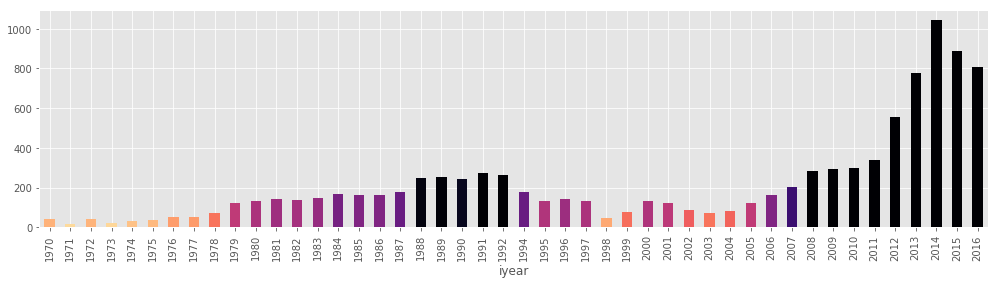

In [155]:
## View Global Terrorism attack weapon volumes by type
# colors = cm.get_cmap('jet')
x = terrorism_df.groupby(['iyear']).size()
fig_size_bi = (17,4)

x.plot(kind='bar', figsize=fig_size_bi, color=cm.magma_r(terrorism_df.groupby(['iyear']).size()))

### A Note on Color Maps

Looking at the above charts, one might ask: "Why use those specific colors and not others?"

The choice of a colormap is in part subjective, but some objective qualities can be applied to help make the determination. Primarily, we care to distinguish our data's **sequential** nature from time-step to time-step.

In the above case, the visualization serves to show fluctuating intensities across time (though we will get to better methods for this). Color maps can be grouped into the following: {**Perceptually Uniform Sequential**, **Sequential**, **Miscellaneous**}.

- **Miscellaneous**
 - The majority of color maps. These can be palettes designed purely for aesthetics. Many are designated for categorical data while others have arbitrarily chosen interpolations between 2 subjective colors.
- **Sequential**
 - Humans register both light intensity and color. While intensity is more easily described by a single magnitude, there are many methods for parameterizing color (e.g. RGB, CMYK, etc.). Sequential methods attempt to describe a uniform 2D projection, given any color map, to genereate a consistent gradient along intensity. 
- **Perceptually Uniform Sequential**
 - These projections take the sequential aspect one step further and, instead of simply progressing in the "correct" direction of a color gradient, they attempt to make all steps "equal". Further complicating this is the fact that individual color maps behave differently with perceived intensity. Regardless, most occassions are "best" visualized by this category of color maps.
 

Let's test this by viewing the same graphs, but with data labels obscured.

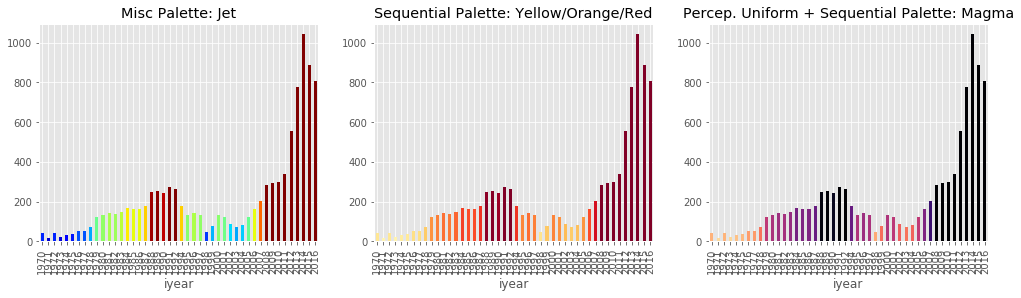

In [168]:
## View Global Terrorism attack weapon volumes by type
# colors = cm.get_cmap('jet')
x = terrorism_df.groupby(['iyear']).size()
fig_size_bi = (17,4)

plt.subplot(1, 3, 1)
x.plot(title='Misc Palette: Jet', kind='bar', figsize=fig_size_bi, color=cm.jet(terrorism_df.groupby(['iyear']).size()))
plt.subplot(1, 3, 2)
x.plot(title='Sequential Palette: Yellow/Orange/Red', kind='bar', figsize=fig_size_bi, color=cm.YlOrRd(terrorism_df.groupby(['iyear']).size()))
plt.subplot(1, 3, 3)
x.plot(title='Percep. Uniform + Sequential Palette: Magma', kind='bar', figsize=fig_size_bi, color=cm.magma_r(terrorism_df.groupby(['iyear']).size()))

Scanning left to right, more sensibile color maps become immediately apparent.

Objective Objective:
 - In Jet, the transitions from Blue to Green and Yellow to Deep Red are incongruous. This is because it is stepping through perceived luminence via bright colors before returning to dark. Sequential maps will attempt to pair the two.

Subjective Evaluation:
 - The start and end points of the color map are important. Using Jet as an example, the center of the map uses green, which is commonly used to suggest optimality or normality. In this scenario, however, we would not want to suggest **normal** levels of global terror.

## Pie-Chart

Display the ratio of Terrorism weapon types to view relative changes.

In [ ]:
## Display the ratio of total Terrorism weapon types.



In [ ]:
## Display the relative changes of weapon choices over time.

## Histogram

## Box and Whisker Plot

## Scatter Plots 
Can see how some of the data may be realted based on scatter plots generated:
    1. Latitude vs Longitude shows us the location of attacks. 
        *Could underlay a map to get a better visual if wanted.    

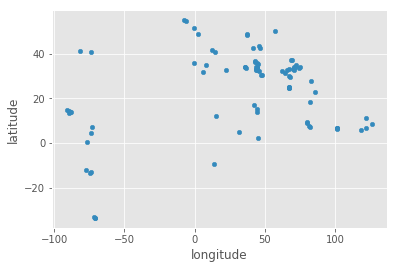

In [4]:
year_lat_df = terrorism_df[0:100][['latitude', 'longitude']]

year_lat_df.plot.scatter(x='longitude',y='latitude')

### Testing clustering on Latitude and Longitude
      1. Use K-means algorthim to cluster points to two groups based on "closeness"
      2. Use colormap to view the different clusters

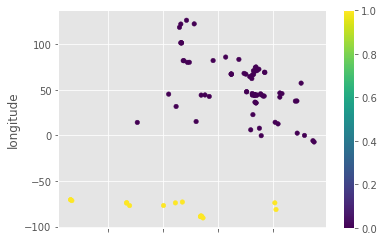

In [5]:
from sklearn.cluster import KMeans

cl = sk.cluster.KMeans(n_clusters=2).fit(year_lat_df)

year_lat_df.plot.scatter(x='latitude',y='longitude', c=cl.labels_, colormap='viridis')

### One hot encoding

One hot encoding deals with our categorical variables by creating an <em>n-dimensional</em> row vector per category.

* Specify columns
* Get dummy variables
    * Optionally append to previous dataframe

In [6]:
#create new data frame with the dummy variables included
t_dummies_df = pd.get_dummies(terrorism_df, columns=['weaptype1', 'region'], dtype=bool)


## Pair Plots

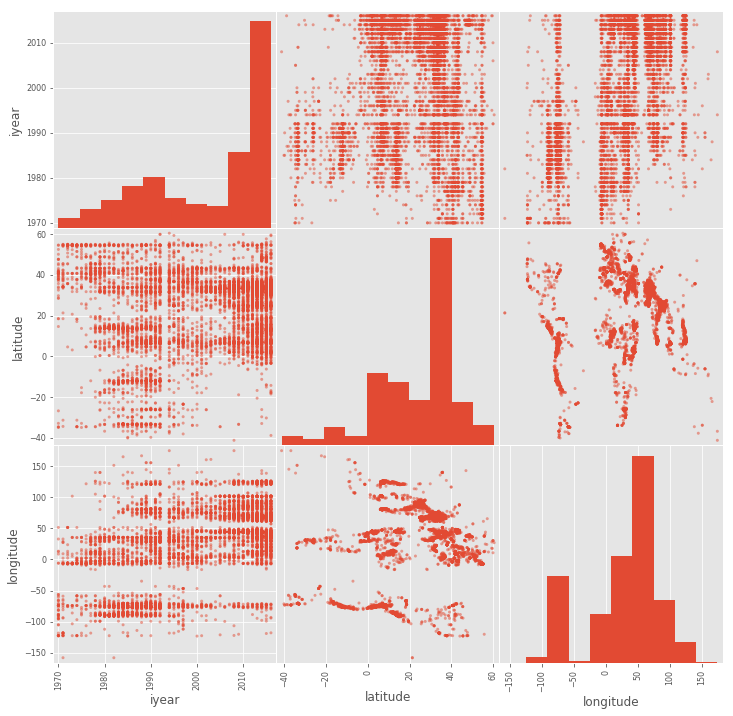

In [7]:
#Plots each variable with each other and displays a matrix of different plots
scatter_matrix(terrorism_df[['iyear', 'latitude', 'longitude']], figsize=(12, 12))
plt.show()

#  Example of Data Exploration Possibility
    Questions:
        1. Is there a certain time during the year that attacks are more frequent?
    

### Subsection 1: Time of Year

In [8]:
#View plot of months over years to see if any common/uncommon attack months
#scatter_matrix(terrorism_df[['iyear', 'imonth', 'iday']], figsize=(12, 12))
#scatter_matrix(terrorism_df[['region']], figsize=(12, 12))
#plt.show()

#Create a encoding that makes true/false columns for each month
#months_region_dummies_df = pd.get_dummies(terrorism_df, columns=['region'], dtype=bool)




#### Line plot of Global Monthly Trend


In [9]:
# Line plot of events over time
# grouped_terr_df = terrorism_df.groupby(['datetime']).count()

datetime_df = terrorism_df.set_index('datetime')

start_date = '1970-01-1'
end_date = '2017-01-01'

# daily_terr_df = datetime_df[start_date:end_date].groupby(pd.Grouper(freq='D')).count()
monthly_terr_df = datetime_df[start_date:end_date].groupby(pd.Grouper(freq='M')).count()

monthly_terr_df.iloc[0:10]

#check to make sure count worked properly
# check_df = terrorism_df[(terrorism_df['imonth']== 8 ) & (terrorism_df['iyear']== 2014 )]
# check_df.iloc[0:]
                        
#daily_terr_df['eventid'].plot(kind='line', figsize=[30,5])
#monthly_terr_df['eventid'].plot(kind='line', figsize=[30,5])

# fig, ax = plt.subplots(figsize=(15,7))
# .groupby(['date','type']).count()['amount'].plot(ax=ax)


#####################################################################################################
# ADDED COLUMN FOR REGION 10 SUM FOR EASY PLOTTING
# monthly_terr_df['region_10_sum'] = datetime_df[start_date:end_date].groupby(pd.Grouper(freq='M'))['region_10'].sum()
# monthly_terr_r_10_df = [start_date:end_date].groupby(pd.Grouper(freq='M')).count()
# monthly_terr_df['region_10_sum'].plot(kind='line', figsize=[25,10])
# monthly_terr_df.iloc[0:20]

# region_10_df.plot(kind='line', figsize=[30,5])
# plt.savefig('./terr_event_date.png')
# region_10_df / monthly_terr_df['']
# ratio = region_10_df[''] / monthly_terr_df
# monthly_terr_df.plot(x=monthly_terr_df.index, y='region_10_sum', kind='line', figsize=[25,5])
#######################################################################################################

,eventid,iyear,imonth,iday,country,region,latitude,longitude,crit1,crit2,crit3,attacktype1,targtype1,targsubtype1,weaptype1,weapsubtype1
datetime,,,,,,,,,,,,,,,,
1970-01-31,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
1970-02-28,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1970-03-31,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
1970-04-30,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
1970-05-31,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
1970-06-30,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
1970-07-31,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
1970-08-31,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
1970-09-30,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


### Global Monthly Trend
    Our graph above shows a possible global monthly trend for attack occurances. I am going to start exploring possible
    reasons for the frequency of attacks in Jan and Dec. 


#### Scatter Plot of Jan and Dec dataframe to look for possible Region differences

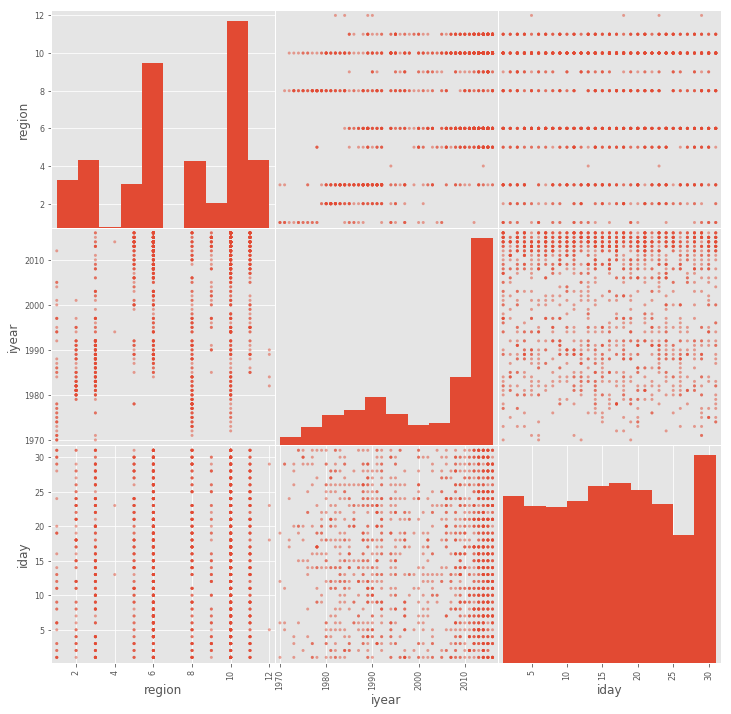

In [10]:
#Make new dataframe with only months of Jan and Dec
DecJan_terrorism_df = terrorism_df[((terrorism_df['imonth']== 1) | (terrorism_df['imonth'] == 12))]
#DecJan_terrorism_df = terrorism_df[(terrorism_df['iyear']>2011) & ((terrorism_df['imonth']== 1) | (terrorism_df['imonth'] == 12))]
scatter_matrix(DecJan_terrorism_df[['region', 'iyear', 'iday']], figsize=(12, 12))
plt.show()

#DecJan_terrorism_df.iloc[0:]

#year_lat_df = DecJan_terrorism_df[0:100][['latitude', 'longitude']]
#year_lat_df.plot.scatter(x='longitude',y='latitude')

#### Removing Regions
Region 6 and 10 account for over half the number of attacks. Will removing these regions effect our monthly trend? 

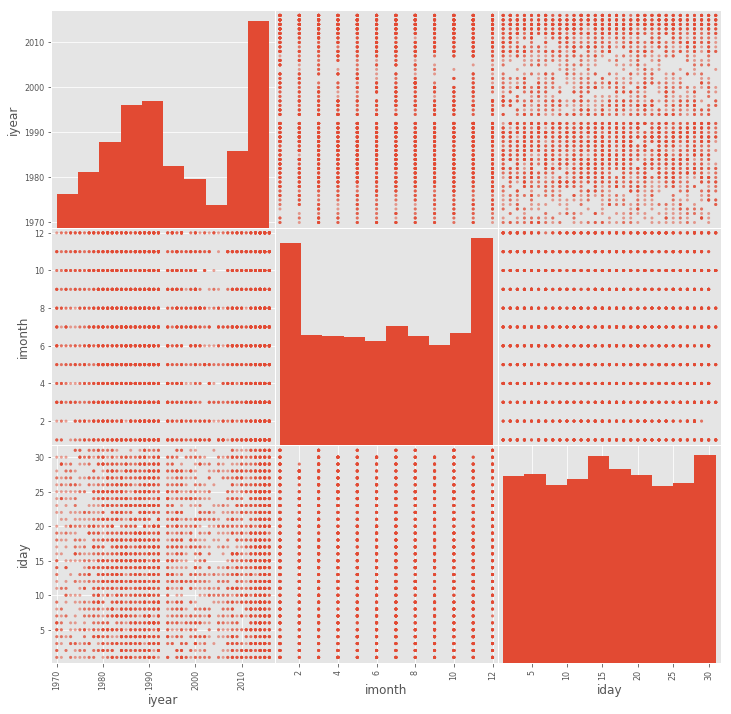

In [11]:
#make a new dataframe removing region 10 & 6:
region_df = terrorism_df[((terrorism_df['region'] != 10) & (terrorism_df['region'] !=6))]

scatter_matrix(region_df[['iyear', 'imonth', 'iday']], figsize=(12, 12))
plt.show()

#region_df.iloc[0:]

## Map Overlay

Text(0.5,0,'Global Attacks')

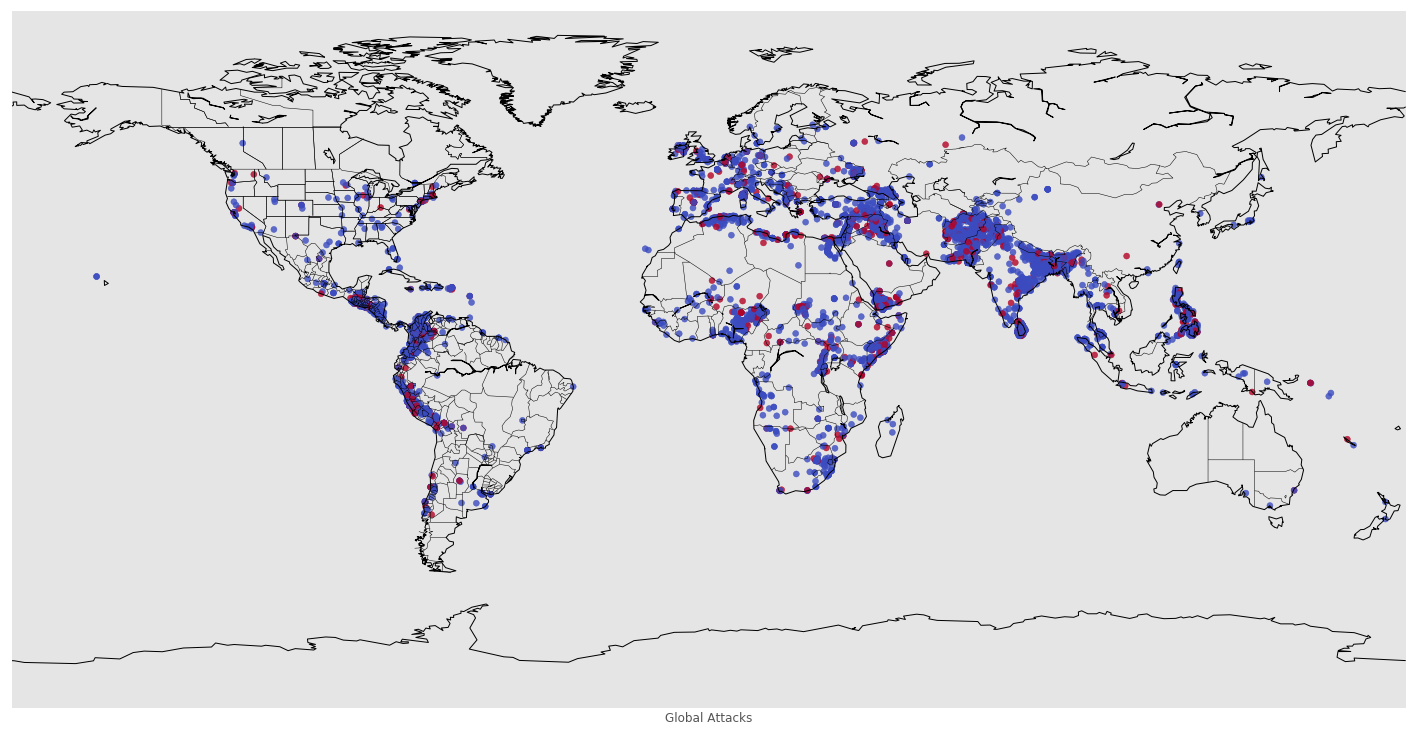

In [12]:
#make new column IS jan or Dec
#plot that with lat and long and color by "is Jan or Dec"
test_df = terrorism_df.copy()
test_df['is_jan_dec']= (test_df['imonth']== 12) |(test_df['imonth']==1)
#test_df.iloc[0:10]
#test_df.plot.scatter(x='longitude',y='latitude', c=test_df['is_jan_dec'], cmap='Wistia', figsize=[20,10])
# viridis

# DecJan_terrorism_df[(DecJan_terrorism_df['datetime'].dt.month == 12) | (DecJan_terrorism_df['datetime'].dt.month == 1)]

# year_lat_df = DecJan_terrorism_df[0:100][['latitude', 'longitude']]
# year_lat_df.plot.scatter(x='longitude',y='latitude')

fig, ax = plt.subplots(figsize = (25,25))
earth = Basemap(ax=ax)
earth.drawcoastlines()
earth.drawcountries()
earth.drawstates()

ax.scatter(test_df['longitude'], test_df['latitude'], c=test_df['is_jan_dec'] , 
           cmap = 'coolwarm', alpha=0.8)
ax.set_xlabel("Global Attacks")
#fig.savefig('usgs-monthly-4.5M.png')

## Line Plot

### Time Series graph for Regional Monthly Attacks

##### Observations
* 

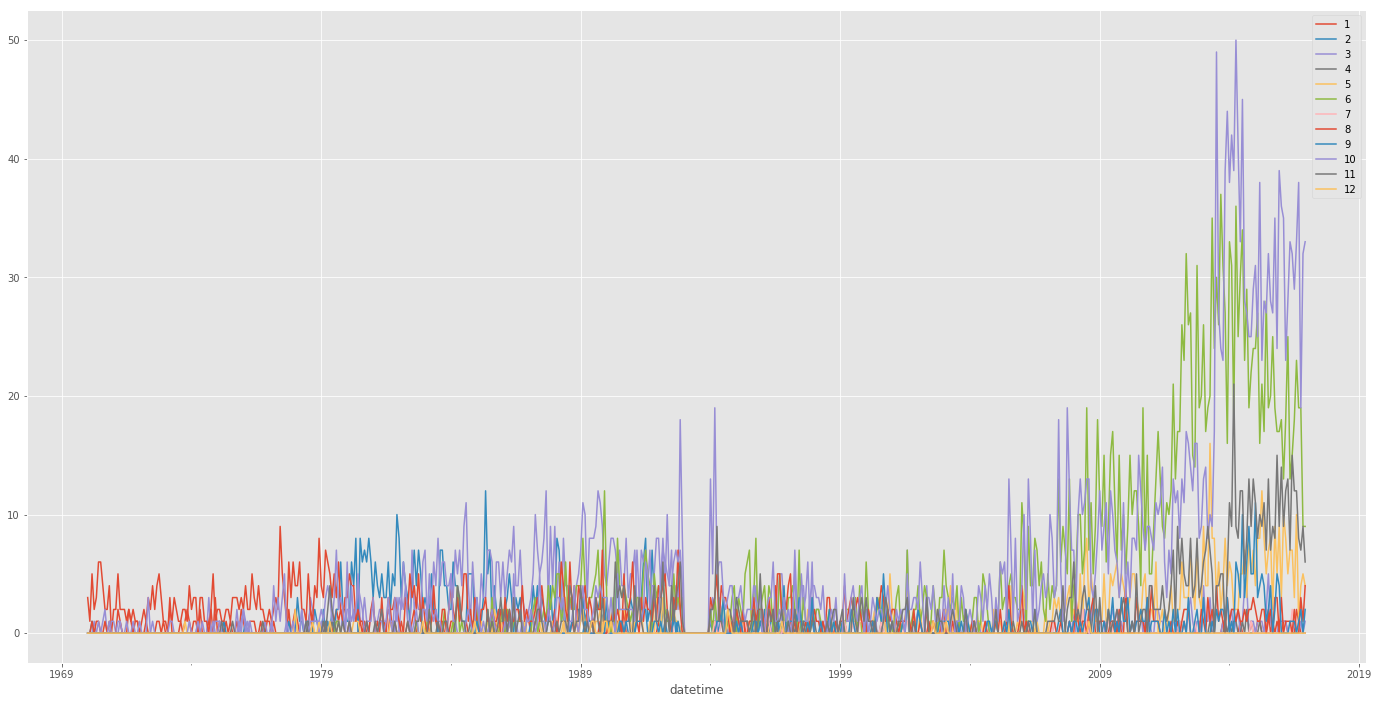

In [13]:
#Plot monthly trend for each region

regional_dummies = pd.get_dummies(datetime_df['region'])
regional_dummies.groupby(pd.Grouper(freq='M')).sum().plot(kind='line', figsize=[24,12] )

## Results
    There does not appear to be a large difference among Regions. 
    
    NOTES:
    Combine alike lines
    compare degree of difference between different lines (regions)
    Why may the regions be similar or different
    
    maybe to think about:
    ---Relative attack freguency non maximal supression----
        size of place and # of attacks
        
        